### Word Embeddings: CBOW y Skip-Gram

### Instalación de Librerías

In [1]:
!pip install gensim nltk tqdm

DEPRECATION: Loading egg at c:\programdata\miniconda3\lib\site-packages\vboxapi-1.0-py3.12.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330


### Modelo

In [6]:
import json
import random

import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS as GENSIM_STOP
from gensim.models import Word2Vec, Phrases
from gensim.models.phrases import Phraser
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from tqdm import tqdm

# -------------------------------------------------
# 1. Descargas NLTK (solo la primera vez)
# -------------------------------------------------
nltk.download('stopwords', quiet=True)

# -------------------------------------------------
# 2. Definir stopwords en español y stemmer
# -------------------------------------------------
nltk_stop = set(stopwords.words('spanish'))
stemmer = SnowballStemmer('spanish')

# -------------------------------------------------
# 3. Función de preprocesado (tokenización + stemming)
# -------------------------------------------------
def preprocess(texto: str) -> list[str]:
    """
    1) Convierte a minúsculas y tokeniza quitando puntuación y acentos (deacc=True).
    2) Filtra tokens de longitud <= 3.
    3) Elimina stopwords de gensim y NLTK.
    4) Aplica stemming en español.
    Devuelve la lista de stems resultantes.
    """
    tokens = simple_preprocess(texto, deacc=True)
    tokens = [t for t in tokens if len(t) > 3 and t not in GENSIM_STOP and t not in nltk_stop]
    stems = [stemmer.stem(t) for t in tokens]
    return stems

# -------------------------------------------------
# 4. (Opcional) Detectar bigramas para enriquecer el corpus
# -------------------------------------------------
def aplicar_bigramas(
        documentos: list[list[str]],
        min_count: int = 5,
        threshold: float = 100.0
) -> tuple[list[list[str]], Phraser]:
    """
    1) Entrena un modelo de bigramas sobre los documentos tokenizados.
    2) Devuelve los documentos enriquecidos con bigramas y el modelo Phraser.
    """
    bigram = Phrases(documentos, min_count=min_count, threshold=threshold, progress_per=10000)
    bigram_mod = Phraser(bigram)
    documentos_bi = [bigram_mod[doc] for doc in documentos]
    return documentos_bi, bigram_mod

# -------------------------------------------------
# 5. Leer el JSON y preprocesar toda la columna 'description'
# -------------------------------------------------
def leer_y_preprocesar(ruta_json: str, use_bigrams: bool = False) -> tuple[pd.DataFrame, list[list[str]]]:
    """
    1) Lee el JSON (lista de objetos) y extrae las columnas 'description' y 'category'.
    2) Por cada fila, aplica preprocess() a 'description' y guarda los stems en una lista.
    3) Si use_bigrams=True, detecta bigramas en todo el corpus y los aplica.
    Devuelve:
      - df (DataFrame) con columnas ['description', 'category']
      - lista de documentos tokenizados/stemmizados (con o sin bigramas).
    """
    # Cargar el JSON como DataFrame
    with open(ruta_json, 'r', encoding='utf-8') as f:
        data = json.load(f)
    df = pd.DataFrame(data)

    # Filtrar descripciones vacías
    df = df[df['description'].notna() & (df['description'].str.strip() != "")].reset_index(drop=True)

    # Preprocesar cada descripción
    documentos = []
    for texto in tqdm(df['description'].astype(str), desc="Preprocesando (stemming)..."):
        stems = preprocess(texto)
        if len(stems) >= 1:
            documentos.append(stems)
        else:
            documentos.append([])

    # Si se usan bigramas
    if use_bigrams:
        documentos_bi, modelo_bigram = aplicar_bigramas(documentos, min_count=5, threshold=100.0)
        return df, documentos_bi

    return df, documentos

# -------------------------------------------------
# 6. Entrenar Word2Vec (CBOW y Skip-Gram)
# -------------------------------------------------
def entrenar_word2vec(
        documentos_tokenizados: list[list[str]],
        vector_size: int = 100,
        window: int = 5,
        min_count: int = 5,
        sg: int = 0,
        epochs: int = 10
) -> Word2Vec:
    """
    Parámetros de Word2Vec:
      - documentos_tokenizados: lista de listas de stems para cada “noticia”.
      - vector_size: dimensión del embedding.
      - window: tamaño de la ventana de contexto.
      - min_count: filtra tokens con frecuencia < min_count.
      - sg: 0 para CBOW, 1 para Skip-Gram.
      - epochs: número de iteraciones de entrenamiento.
    Devuelve el modelo Word2Vec entrenado.
    """
    modelo = Word2Vec(
        sentences=documentos_tokenizados,
        vector_size=vector_size,
        window=window,
        min_count=min_count,
        sg=sg,
        epochs=epochs,
        seed=42,
        workers=4  # ajusta según tu CPU
    )
    return modelo

# -------------------------------------------------
# 7. Calcular vector de documento como promedio de embeddings de palabras
# -------------------------------------------------
def vector_documento(modelo_w2v: Word2Vec, tokens: list[str]) -> np.ndarray:
    """
    Dado un modelo Word2Vec y una lista de stems (tokens),
    devuelve el vector promedio de aquellos tokens que estén en el vocabulario.
    Si ninguno está en el vocabulario, devuelve vector cero de dimensión adecuada.
    """
    dim = modelo_w2v.vector_size
    vs = np.zeros(dim, dtype=float)
    count = 0
    for tok in tokens:
        if tok in modelo_w2v.wv.key_to_index:
            vs += modelo_w2v.wv[tok]
            count += 1
    if count > 0:
        vs /= count
    return vs


### Entrenamiento

In [7]:

# -------------------------------------------------
# 8. Función principal: pipeline completo
# -------------------------------------------------
RUTA_JSON = "gestionspider5.json"   # Ajusta si tu JSON tiene otro nombre
USAR_BIGRAMS = False          # True si deseas añadir bigramas
VECTOR_SIZE = 100             # Dimensión de los embeddings
WINDOW = 5                    # Tamaño de la ventana de contexto
MIN_COUNT = 5                 # Filtra tokens raros
EPOCHS = 10                   # Épocas de entrenamiento

# 1) Leer + preprocesar (con o sin bigramas)
df, documentos = leer_y_preprocesar(RUTA_JSON, use_bigrams=USAR_BIGRAMS)
print(f"\nSe obtuvieron {len(df)} noticias con descripción válida.\n")

# 2) Entrenar modelo CBOW (sg=0)
print("=== Entrenando Word2Vec CBOW (sg=0) ... ===")
modelo_cbow = entrenar_word2vec(
    documentos_tokenizados=documentos,
    vector_size=VECTOR_SIZE,
    window=WINDOW,
    min_count=MIN_COUNT,
    sg=0,  # CBOW
    epochs=EPOCHS
)
print("► Modelo CBOW entrenado.\n")

# 3) Entrenar modelo Skip-Gram (sg=1)
print("=== Entrenando Word2Vec Skip-Gram (sg=1) ... ===")
modelo_sg = entrenar_word2vec(
    documentos_tokenizados=documentos,
    vector_size=VECTOR_SIZE,
    window=WINDOW,
    min_count=MIN_COUNT,
    sg=1,  # Skip-Gram
    epochs=EPOCHS
)
print("► Modelo Skip-Gram entrenado.\n")

Preprocesando (stemming)...: 100%|██████████| 1292/1292 [00:05<00:00, 250.85it/s]



Se obtuvieron 1292 noticias con descripción válida.

=== Entrenando Word2Vec CBOW (sg=0) ... ===
► Modelo CBOW entrenado.

=== Entrenando Word2Vec Skip-Gram (sg=1) ... ===
► Modelo Skip-Gram entrenado.



### Busqueda de palabras similares a: extorsión, papa, crecimiento.

In [8]:
# 4) Mostrar palabras similares para ambos modelos
palabras_consulta = {
    "extorsion":  "extorsión (stem → 'extorsion')",
    "papa":       "Papa (stem → 'papa')",
    "crecimient": "crecimiento (stem → 'crecimient')"
}
topn = 5
for modelo, nombre in [(modelo_cbow, "CBOW"), (modelo_sg, "Skip-Gram")]:
    print(f"----- Resultado de {nombre} -----\n")
    for stem_palabra, desc in palabras_consulta.items():
        print(f"* Buscando alrededor de '{desc}':")
        if stem_palabra not in modelo.wv.key_to_index:
            print(f"   ❗ La palabra '{stem_palabra}' no está en el vocabulario.\n")
            continue
        similares = modelo.wv.most_similar(stem_palabra, topn=topn)
        for sim_pal, punt in similares:
            print(f"   • {sim_pal:<15}  (similitud: {punt:.4f})")
        print()
    print()

----- Resultado de CBOW -----

* Buscando alrededor de 'extorsión (stem → 'extorsion')':
   • violenci         (similitud: 0.9669)
   • sicariat         (similitud: 0.9566)
   • delincuent       (similitud: 0.9239)
   • agrav            (similitud: 0.9188)
   • delict           (similitud: 0.9168)

* Buscando alrededor de 'Papa (stem → 'papa')':
   ❗ La palabra 'papa' no está en el vocabulario.

* Buscando alrededor de 'crecimiento (stem → 'crecimient')':
   • avanc            (similitud: 0.9250)
   • recuper          (similitud: 0.8941)
   • digit            (similitud: 0.8939)
   • crec             (similitud: 0.8811)
   • proyeccion       (similitud: 0.8735)


----- Resultado de Skip-Gram -----

* Buscando alrededor de 'extorsión (stem → 'extorsion')':
   • sicariat         (similitud: 0.8096)
   • violenci         (similitud: 0.7940)
   • crimen           (similitud: 0.7893)
   • criminal         (similitud: 0.7815)
   • aragu            (similitud: 0.7660)

* Buscando alrededor de

### Gráfico de 2 dimensiones, usando T-SNE y PCA

=== Construyendo vectores de documento (promedio de embeddings)... ===
Se eligen categorías para mostrar: 'Economía' y 'Perú'.

=== Reduciendo con t-SNE y PCA ... Esto puede tardar un momento. ===


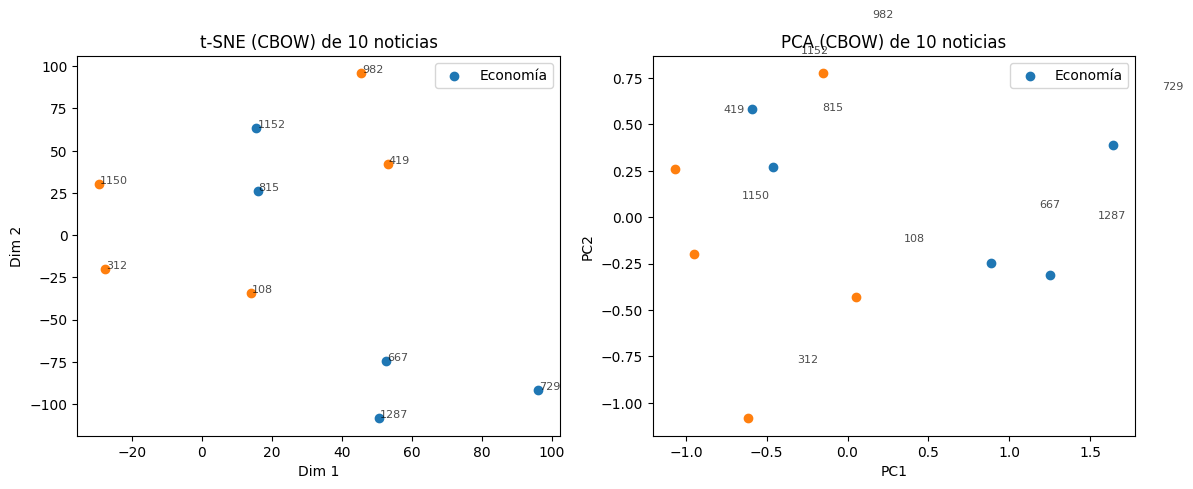


Los números al lado de cada punto corresponden al índice de la noticia en el JSON.


In [9]:
# 5) Construir vectores de documento (promedio de embeddings de palabras)
print("=== Construyendo vectores de documento (promedio de embeddings)... ===")
vectores_cbow = np.array([vector_documento(modelo_cbow, doc) for doc in documentos])
vectores_sg   = np.array([vector_documento(modelo_sg, doc)   for doc in documentos])

# 6) Seleccionar dos categorías para visualizar
categorias_mas_comunes = df['category'].value_counts().index.tolist()
if len(categorias_mas_comunes) < 2:
    raise ValueError("Se necesitan al menos dos categorías distintas en el JSON.")
cat1 = categorias_mas_comunes[0]
cat2 = categorias_mas_comunes[1]
print(f"Se eligen categorías para mostrar: '{cat1}' y '{cat2}'.\n")

# Filtrar índices de 5 noticias aleatorias de cada categoría
idx_cat1 = df[df['category'] == cat1].index.tolist()
idx_cat2 = df[df['category'] == cat2].index.tolist()
if len(idx_cat1) < 5 or len(idx_cat2) < 5:
    raise ValueError(f"No hay suficientes noticias en '{cat1}' o '{cat2}' para tomar 5 de cada una.")

sample_cat1 = random.sample(idx_cat1, 5)
sample_cat2 = random.sample(idx_cat2, 5)
muestras_idx = sample_cat1 + sample_cat2

# Crear etiquetas para colorear más tarde
etiquetas = [cat1]*5 + [cat2]*5

# 7) Reducir dimensionalidad con t-SNE y PCA (usaremos vectores CBOW en este ejemplo)
vectores_muestra = vectores_cbow[muestras_idx]
print("=== Reduciendo con t-SNE y PCA ... Esto puede tardar un momento. ===")

# A) t-SNE con perplexity menor que el número de muestras (10)
tsne = TSNE(n_components=2,
            random_state=42,
            init='pca',
            learning_rate='auto',
            perplexity=5)  # ahora perplexity < 10
coords_tsne = tsne.fit_transform(vectores_muestra)

# B) PCA
pca = PCA(n_components=2, random_state=42)
coords_pca = pca.fit_transform(vectores_muestra)

# 8) Dibujar ambos gráficos
plt.figure(figsize=(12, 5))

# Plot t-SNE
plt.subplot(1, 2, 1)
for i, label in enumerate(etiquetas):
    x, y = coords_tsne[i]
    color = 'tab:blue' if label == cat1 else 'tab:orange'
    plt.scatter(x, y, c=color, label=label if i < 5 else "")
    plt.text(x+0.3, y+0.3, str(muestras_idx[i]), fontsize=8, alpha=0.7)
plt.title("t-SNE (CBOW) de 10 noticias")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
handles, labels_ = plt.gca().get_legend_handles_labels()
plt.legend(dict(zip(labels_, handles)).values(), dict(zip(labels_, handles)).keys())

# Plot PCA
plt.subplot(1, 2, 2)
for i, label in enumerate(etiquetas):
    x, y = coords_pca[i]
    color = 'tab:blue' if label == cat1 else 'tab:orange'
    plt.scatter(x, y, c=color, label=label if i < 5 else "")
    plt.text(x+0.3, y+0.3, str(muestras_idx[i]), fontsize=8, alpha=0.7)
plt.title("PCA (CBOW) de 10 noticias")
plt.xlabel("PC1")
plt.ylabel("PC2")
handles, labels_ = plt.gca().get_legend_handles_labels()
plt.legend(dict(zip(labels_, handles)).values(), dict(zip(labels_, handles)).keys())

plt.tight_layout()
plt.show()
print("\nLos números al lado de cada punto corresponden al índice de la noticia en el JSON.")